In [16]:
from Tester import Tester 
import robot_color_tracking as track
import numpy as np
    
kernel = ((0,1,0),(1,1,1),(0,1,0))

trackers = {
    'achromatic': track.AchromaticTrack(elimination=False,post_erosion=True,d=40,img_width=600, binaryThreshold= 40,hueTolerance=15,
                                        satTolerance=0, kernel = kernel, convolution=True,
                                        colors=['red','springGreen','skyBlue','yellow']),
    'colors_naive': track.ColorTrack(img_width=600,elimination=False,post_erosion=True,satTolerance= 110,binaryThreshold = 60, hueTolerance = 15,
                                     kernel = kernel, colors=['red','springGreen','skyBlue','yellow']),
}
tester = Tester(trackers=trackers,id_options=['red','springGreen','skyBlue','yellow'])
tester.load_positions()
tester.evaluate_error()
tester.save_error_and_time()
# tester.load_error()
# pos_data = tester.filter_place_methods(tester.positions_data, 'night center bulb')
# err = tester.filter_place_methods(tester.error, 'night center bulb')
tester.get_statistics_by_id() # pos_data=pos_data, err=err

Tester was initialized
Real positions loaded
achromatic: 0.00%    i: 0

/usr/lib/python3/dist-packages/scipy/ndimage/measurements.py:431: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or


achromatic: 100.00%    i: 50
colors_naive: 100.00%    i: 120
Error measures and time measures are saved
Statistics calculated


/home/xilinx/jupyter_notebooks/Robot-Tracking-System/src/Tester.py:246: RuntimeWarning: Mean of empty slice.
  self.statistics[m][robot_id]['angle_mean'] = angles.mean()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'achromatic': {'red': {'angle_mean': nan,
   'detected': 88.23529411764706,
   'distance_deviation': 14.879683057750952,
   'distance_mean': 27.966343182553853,
   'false_negative': 11.764705882352942,
   'false_positive': 117.22689075630252,
   'total_img': 126,
   'total_positions': 238},
  'skyBlue': {'angle_mean': nan,
   'detected': 82.17821782178218,
   'distance_deviation': 19.8641353422909,
   'distance_mean': 34.18407413916522,
   'false_negative': 17.821782178217823,
   'false_positive': 37.95379537953795,
   'total_img': 155,
   'total_positions': 303},
  'springGreen': {'angle_mean': nan,
   'detected': 99.2831541218638,
   'distance_deviation': 11.473899615154586,
   'distance_mean': 28.65185213708573,
   'false_negative': 0.7168458781362007,
   'false_positive': 2.150537634408602,
   'total_img': 141,
   'total_positions': 279},
  'time': 4.8727796744771945,
  'yellow': {'angle_mean': nan,
   'detected': 94.81481481481481,
   'distance_deviation': 12.792872089973415,
   

In [106]:
import numpy as np
import matplotlib.pyplot as plt 

stat = {}
colors = tester.id_options
mm_per_px = 0.84

for p in ['daylight','night left bulb','night center bulb','night right bulb',]:
    pos_data = tester.filter_place_methods(tester.positions_data, p)
#     print(pos_data)
    err = tester.filter_place_methods(tester.error, p)
    tester.get_statistics_by_id(pos_data=pos_data, err=err) #
    stat[p] = dict(tester.statistics)
# print(stat)

tex = '\subsection{Detectados}\n\n'


tex+= '\\begin{table}[htb]\n'
tex+= '\centering\n'
tex+='\\begin{tabular}{|l|l|l|l|l|l|l|l|l|}\n'
tex+='\hline'
tex+='                     & \multicolumn{4}{l|}{\\textbf{Luz solar}}                               & \multicolumn{4}{l|}{\\textbf{Lâmpada à esquerda(noite)}}               \\\\ \hline\n'
tex+='                     & \\textbf{Vermelho} & \\textbf{Verde} & \\textbf{Azul} & \\textbf{Amarelo} & \\textbf{Vermelho} & \\textbf{Verde} & \\textbf{Azul} & \\textbf{Amarelo} \\\\ \hline\n'
tex+='\\textbf{Acromático}  '
for c in colors:
    tex+='& '+str(format(stat['daylight']['achromatic'][c]['detected'],'.2f'))+ '\% '
for c in colors:
    tex+='& '+str(format(stat['night left bulb']['achromatic'][c]['detected'],'.2f'))+ '\% '
tex+=' \\\\ \hline\n'
tex+='\\textbf{Morfológico}  '
for c in colors:
    tex+='& '+str(format(stat['daylight']['colors_naive'][c]['detected'],'.2f'))+ '\% '
for c in colors:
    tex+='& '+str(format(stat['night left bulb']['colors_naive'][c]['detected'],'.2f'))+ '\% '
tex+=' \\\\ \hline\n'
tex+='                     & \multicolumn{4}{l|}{\\textbf{Lâmpada ao centro(noite)}}                & \multicolumn{4}{l|}{\\textbf{Lâmpada à direita(noite)}}                \\\\ \hline\n'
tex+='                     & \\textbf{Vermelho} & \\textbf{Verde} & \\textbf{Azul} & \\textbf{Amarelo} & \\textbf{Vermelho} & \\textbf{Verde} & \\textbf{Azul} & \\textbf{Amarelo} \\\\ \hline\n'
tex+='\\textbf{Acromático}  '
for c in colors:
    tex+='& '+str(format(stat['night center bulb']['achromatic'][c]['detected'],'.2f'))+ '\% '
for c in colors:
    tex+='& '+str(format(stat['night right bulb']['achromatic'][c]['detected'],'.2f'))+ '\% '
tex+=' \\\\ \hline\n'
tex+='\\textbf{Morfológico}  '
for c in colors:
    tex+='& '+str(format(stat['night center bulb']['colors_naive'][c]['detected'],'.2f'))+ '\% '
for c in colors:
    tex+='& '+str(format(stat['night right bulb']['colors_naive'][c]['detected'],'.2f'))+ '\% '
tex+=' \\\\ \hline\n'
tex+='\end{tabular}\n'
tex+='\end{table}\n'

tex+= '\n\subsection{Falsos Positivos}\n\n'

tex+= '\\begin{table}[htb]\n'
tex+= '\centering\n'
tex+='\\begin{tabular}{|l|l|l|l|l|l|l|l|l|}\n'
tex+='\hline'
tex+='                     & \multicolumn{4}{l|}{\\textbf{Luz solar}}                               & \multicolumn{4}{l|}{\\textbf{Lâmpada à esquerda(noite)}}               \\\\ \hline\n'
tex+='                     & \\textbf{Vermelho} & \\textbf{Verde} & \\textbf{Azul} & \\textbf{Amarelo} & \\textbf{Vermelho} & \\textbf{Verde} & \\textbf{Azul} & \\textbf{Amarelo} \\\\ \hline\n'
tex+='\\textbf{Acromático}  '
for c in colors:
    tex+='& '+str(format(stat['daylight']['achromatic'][c]['false_positive'],'.2f'))+ '\% '
for c in colors:
    tex+='& '+str(format(stat['night left bulb']['achromatic'][c]['false_positive'],'.2f'))+ '\% '
tex+=' \\\\ \hline\n'
tex+='\\textbf{Morfológico}  '
for c in colors:
    tex+='& '+str(format(stat['daylight']['colors_naive'][c]['false_positive'],'.2f'))+ '\% '
for c in colors:
    tex+='& '+str(format(stat['night left bulb']['colors_naive'][c]['false_positive'],'.2f'))+ '\% '
tex+=' \\\\ \hline\n'
tex+='                     & \multicolumn{4}{l|}{\\textbf{Lâmpada ao centro(noite)}}                & \multicolumn{4}{l|}{\\textbf{Lâmpada à direita(noite)}}                \\\\ \hline\n'
tex+='                     & \\textbf{Vermelho} & \\textbf{Verde} & \\textbf{Azul} & \\textbf{Amarelo} & \\textbf{Vermelho} & \\textbf{Verde} & \\textbf{Azul} & \\textbf{Amarelo} \\\\ \hline\n'
tex+='\\textbf{Acromático}  '
for c in colors:
    tex+='& '+str(format(stat['night center bulb']['achromatic'][c]['false_positive'],'.2f'))+ '\% '
for c in colors:
    tex+='& '+str(format(stat['night right bulb']['achromatic'][c]['false_positive'],'.2f'))+ '\% '
tex+=' \\\\ \hline\n'
tex+='\\textbf{Morfológico}  '
for c in colors:
    tex+='& '+str(format(stat['night center bulb']['colors_naive'][c]['false_positive'],'.2f'))+ '\% '
for c in colors:
    tex+='& '+str(format(stat['night right bulb']['colors_naive'][c]['false_positive'],'.2f'))+ '\% '
tex+=' \\\\ \hline\n'
tex+='\end{tabular}\n'
tex+='\end{table}\n'


tex+= '\n\subsection{Erro médio de distância}\n\n'

tex+= '\\begin{table}[htb]\n'
tex+= '\centering\n'
tex+='\\begin{tabular}{|l|l|l|l|l|l|l|l|l|}\n'
tex+='\hline'
tex+='                     & \multicolumn{4}{l|}{\\textbf{Luz solar}}                               & \multicolumn{4}{l|}{\\textbf{Lâmpada à esquerda(noite)}}               \\\\ \hline\n'
tex+='                     & \\textbf{Vermelho} & \\textbf{Verde} & \\textbf{Azul} & \\textbf{Amarelo} & \\textbf{Vermelho} & \\textbf{Verde} & \\textbf{Azul} & \\textbf{Amarelo} \\\\ \hline\n'
tex+='\\textbf{Acromático}  '
for c in colors:
    tex+='& '+str(format(mm_per_px*stat['daylight']['achromatic'][c]['distance_mean'],'.2f'))+ 'mm '
for c in colors:
    tex+='& '+str(format(mm_per_px*stat['night left bulb']['achromatic'][c]['distance_mean'],'.2f'))+ 'mm '
tex+=' \\\\ \hline\n'
tex+='\\textbf{Morfológico}  '
for c in colors:
    tex+='& '+str(format(mm_per_px*stat['daylight']['colors_naive'][c]['distance_mean'],'.2f'))+ 'mm '
for c in colors:
    tex+='& '+str(format(mm_per_px*stat['night left bulb']['colors_naive'][c]['distance_mean'],'.2f'))+ 'mm '
tex+=' \\\\ \hline\n'
tex+='                     & \multicolumn{4}{l|}{\\textbf{Lâmpada ao centro(noite)}}                & \multicolumn{4}{l|}{\\textbf{Lâmpada à direita(noite)}}                \\\\ \hline\n'
tex+='                     & \\textbf{Vermelho} & \\textbf{Verde} & \\textbf{Azul} & \\textbf{Amarelo} & \\textbf{Vermelho} & \\textbf{Verde} & \\textbf{Azul} & \\textbf{Amarelo} \\\\ \hline\n'
tex+='\\textbf{Acromático}  '
for c in colors:
    tex+='& '+str(format(mm_per_px*stat['night center bulb']['achromatic'][c]['distance_mean'],'.2f'))+ 'mm '
for c in colors:
    tex+='& '+str(format(mm_per_px*stat['night right bulb']['achromatic'][c]['distance_mean'],'.2f'))+ 'mm '
tex+=' \\\\ \hline\n'
tex+='\\textbf{Morfológico}  '
for c in colors:
    tex+='& '+str(format(mm_per_px*stat['night center bulb']['colors_naive'][c]['distance_mean'],'.2f'))+ 'mm '
for c in colors:
    tex+='& '+str(format(mm_per_px*stat['night right bulb']['colors_naive'][c]['distance_mean'],'.2f'))+ 'mm '
tex+=' \\\\ \hline\n'
tex+='\end{tabular}\n'
tex+='\end{table}\n'

## if elimination == true
tex+= '\n\subsection{Erro médio de orientação}\n\n'

tex+= '\\begin{table}[htb]\n'
tex+= '\centering\n'
tex+='\\begin{tabular}{|l|l|l|l|l|l|l|l|l|}\n'
tex+='\hline'
tex+='                     & \multicolumn{4}{l|}{\\textbf{Luz solar}}                               & \multicolumn{4}{l|}{\\textbf{Lâmpada à esquerda(noite)}}               \\\\ \hline\n'
tex+='                     & \\textbf{Vermelho} & \\textbf{Verde} & \\textbf{Azul} & \\textbf{Amarelo} & \\textbf{Vermelho} & \\textbf{Verde} & \\textbf{Azul} & \\textbf{Amarelo} \\\\ \hline\n'
tex+='\\textbf{Acromático}  '
for c in colors:
    tex+='& '+str(format(stat['daylight']['achromatic'][c]['angle_mean'],'.2f'))+ 'º '
for c in colors:
    tex+='& '+str(format(stat['night left bulb']['achromatic'][c]['angle_mean'],'.2f'))+ 'º '
tex+=' \\\\ \hline\n'
tex+='\\textbf{Morfológico}  '
for c in colors:
    tex+='& '+str(format(stat['daylight']['colors_naive'][c]['angle_mean'],'.2f'))+ 'º '
for c in colors:
    tex+='& '+str(format(stat['night left bulb']['colors_naive'][c]['angle_mean'],'.2f'))+ 'º '
tex+=' \\\\ \hline\n'
tex+='                     & \multicolumn{4}{l|}{\\textbf{Lâmpada ao centro(noite)}}                & \multicolumn{4}{l|}{\\textbf{Lâmpada à direita(noite)}}                \\\\ \hline\n'
tex+='                     & \\textbf{Vermelho} & \\textbf{Verde} & \\textbf{Azul} & \\textbf{Amarelo} & \\textbf{Vermelho} & \\textbf{Verde} & \\textbf{Azul} & \\textbf{Amarelo} \\\\ \hline\n'
tex+='\\textbf{Acromático}  '
for c in colors:
    tex+='& '+str(format(stat['night center bulb']['achromatic'][c]['angle_mean'],'.2f'))+ 'º '
for c in colors:
    tex+='& '+str(format(stat['night right bulb']['achromatic'][c]['angle_mean'],'.2f'))+ 'º '
tex+=' \\\\ \hline\n'
tex+='\\textbf{Morfológico}  '
for c in colors:
    tex+='& '+str(format(stat['night center bulb']['colors_naive'][c]['angle_mean'],'.2f'))+ 'º '
for c in colors:
    tex+='& '+str(format(stat['night right bulb']['colors_naive'][c]['angle_mean'],'.2f'))+ 'º '
tex+=' \\\\ \hline\n'
tex+='\end{tabular}\n'
tex+='\end{table}\n'


print(tex)

Statistics calculated
Statistics calculated
Statistics calculated
Statistics calculated

\subsection{Detectados}

\begin{table}[htb]
\centering
\begin{tabular}{|l|l|l|l|l|l|l|l|l|}
\hline                     & \multicolumn{4}{l|}{\textbf{Luz solar}}                               & \multicolumn{4}{l|}{\textbf{Lâmpada à esquerda(noite)}}               \\ \hline
                     & \textbf{Vermelho} & \textbf{Verde} & \textbf{Azul} & \textbf{Amarelo} & \textbf{Vermelho} & \textbf{Verde} & \textbf{Azul} & \textbf{Amarelo} \\ \hline
\textbf{Acromático}  & 88.89\% & 100.00\% & 96.03\% & 98.04\% & 41.82\% & 92.86\% & 41.18\% & 73.91\%  \\ \hline
\textbf{Morfológico}  & 86.67\% & 100.00\% & 81.75\% & 97.06\% & 3.64\% & 0.00\% & 45.10\% & 82.61\%  \\ \hline
                     & \multicolumn{4}{l|}{\textbf{Lâmpada ao centro(noite)}}                & \multicolumn{4}{l|}{\textbf{Lâmpada à direita(noite)}}                \\ \hline
                     & \textbf{Vermelho} & \textbf{Verde} & \te

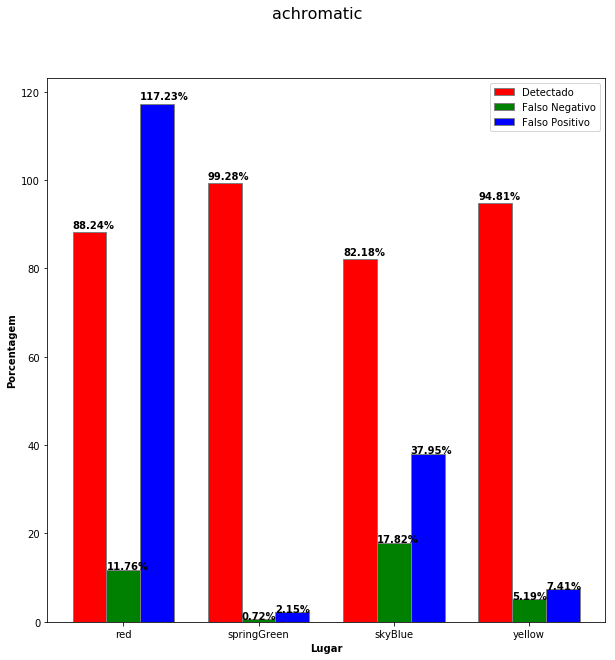

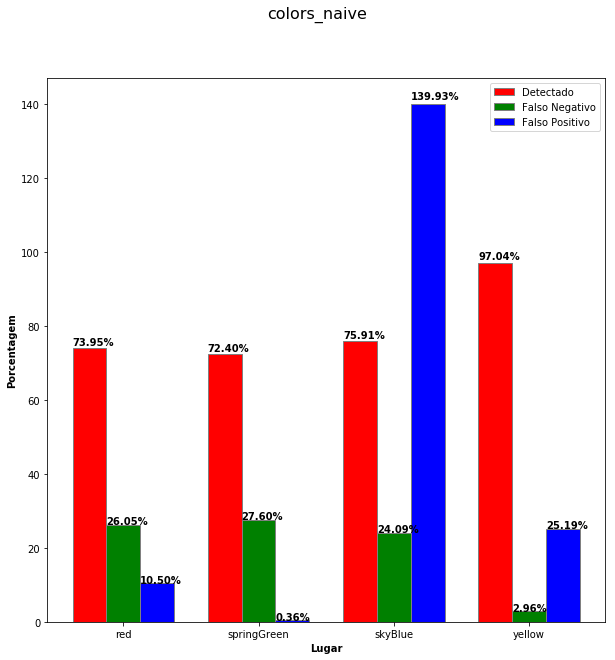

In [17]:
import numpy as np 
import matplotlib.pyplot as plt 

statistics = tester.statistics
controlled_variable = tester.id_options #["daylight", "night right bulb", "night center bulb", "night left bulb"] #
methods = statistics
timeOfTrack = tester.timeOfTrack
# Gráfico com índices de detecção

for m in statistics:
    plt.figure(figsize=(10,10))
    axes = []
    axes.append(plt.bar(range(1, 4*len(controlled_variable), 4), [statistics[m][p]['detected'] for p in controlled_variable], color ='r', width =1, 
            edgecolor ='grey', label ='Detectado') )
    axes.append( plt.bar(range(2, 4*len(controlled_variable), 4), [statistics[m][p]['false_negative'] for p in controlled_variable], color ='g', width = 1, 
            edgecolor ='grey', label ='Falso Negativo') )
    axes.append( plt.bar(range(3, 4*len(controlled_variable), 4), [statistics[m][p]['false_positive'] for p in controlled_variable], color ='b', width = 1, 
            edgecolor ='grey', label ='Falso Positivo') )
    
    # Add annotation to bars
    for ax in axes:
        for i in ax.patches: 
            plt.text(i.xy[0], i.get_height()*1.01,  
                     str(format(i.get_height(), '.2f'))+'%', 
                     fontsize = 10, fontweight ='bold', 
                     color ='black') 
    # Adding Xticks
    plt.xlabel('Lugar', fontweight ='bold') 
    plt.ylabel('Porcentagem', fontweight ='bold') 
    plt.xticks(list(range(2, 4*len(controlled_variable), 4)),
               controlled_variable) 
    plt.suptitle(m, fontsize=16)
    plt.legend()
    plt.savefig('../algorithm_performance_data/graphs/pynq/'+m+'_detections_erosion.png')
    plt.show()

In [18]:
# Gráfico com o erro médio do ângulo esperado 

statistics = tester.statistics
color = ['r', 'g', 'b', 'y']
label = controlled_variable
mm_per_px = 0.84
plt.figure(figsize=(15,10))
for i in range(len(label)):
    ax = plt.bar(range(i+1,5*len(methods),5),[ statistics[m][label[i]]['angle_mean'] for m in methods],
                             color =color[i], width =1, edgecolor ='grey', label =label[i])
    for i in ax.patches: 
        plt.text(i.xy[0], i.get_height()*1.01,  
                 str(format(i.get_height(), '.2f'))+'graus', 
                 fontsize = 10, fontweight ='bold', 
                 color ='black') 

# Adding Xticks
plt.xlabel('Método', fontweight ='bold') 
plt.ylabel('Média do erro(centímetros)', fontweight ='bold') 
plt.xticks([2+5*i for i in range(len(methods))], methods) 
plt.suptitle('Erro Médio(Ângulo)', fontsize=16)   
plt.legend()
plt.savefig('../algorithm_performance_data/graphs/pynq/mean_angle_error_erosion.png')
plt.show()

/usr/lib/python3/dist-packages/matplotlib/axis.py:1032: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/usr/lib/python3/dist-packages/matplotlib/axis.py:1042: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


ValueError: cannot convert float NaN to integer

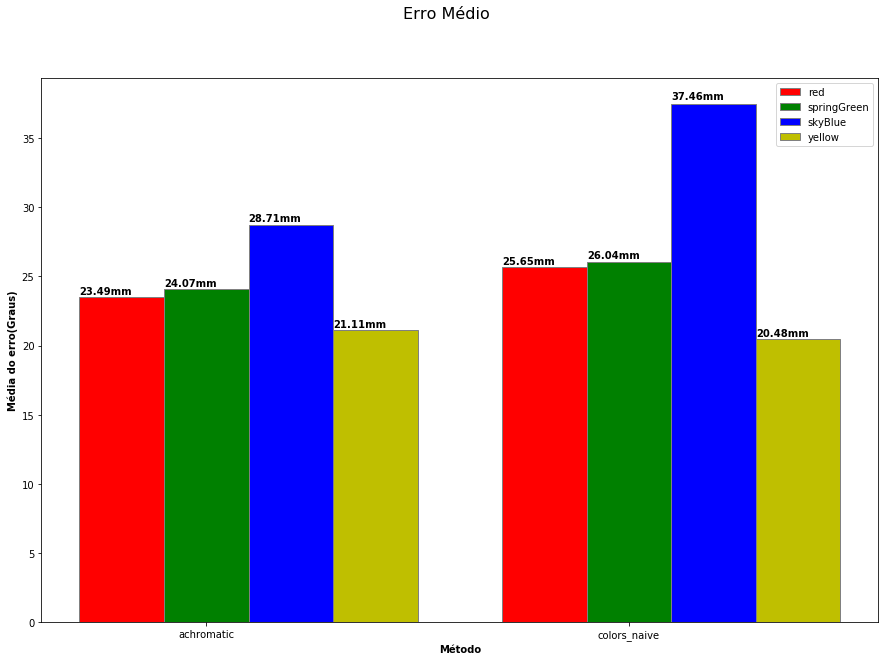

In [19]:
# Gráfico com erro médio da posição esperado

statistics = tester.statistics
color = ['r', 'g', 'b', 'y']
label = controlled_variable
plt.figure(figsize=(15,10))
for i in range(len(label)):
    ax = plt.bar(range(i+1,5*len(methods),5),[ mm_per_px*statistics[m][label[i]]['distance_mean'] for m in methods],
                             color =color[i], width =1, edgecolor ='grey', label =label[i])
    for i in ax.patches: 
        plt.text(i.xy[0], i.get_height()*1.01,  
                 str(format(i.get_height(), '.2f'))+'mm', 
                 fontsize = 10, fontweight ='bold', 
                 color ='black') 

# Adding Xticks
plt.xlabel('Método', fontweight ='bold') 
plt.ylabel('Média do erro(Graus)', fontweight ='bold') 
plt.xticks([2+5*i for i in range(len(methods))], methods) 
plt.suptitle('Erro Médio', fontsize=16)   
plt.legend()
plt.savefig('../algorithm_performance_data/graphs/pynq/mean_distance_error_erosion.png')
plt.show()

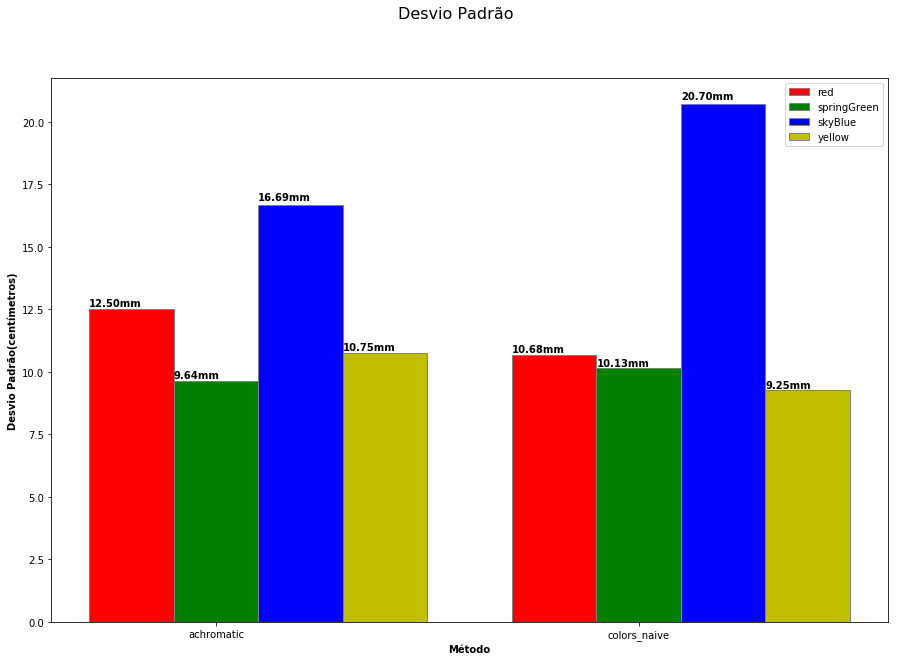

In [20]:
# Gráfico com desvio padrão da média

color = ['r', 'g', 'b', 'y']
label = controlled_variable

plt.figure(figsize=(15,10))
for i in range(len(label)):
    ax = plt.bar(range(i+1,5*len(methods),5),[ mm_per_px*statistics[m][label[i]]['distance_deviation'] for m in methods],
                             color =color[i], width =1, edgecolor ='grey', label =label[i])
    for i in ax.patches: 
        plt.text(i.xy[0], i.get_height()*1.01,  
                 str(format(i.get_height(), '.2f'))+'mm', 
                 fontsize = 10, fontweight ='bold', 
                 color ='black') 

# Adding Xticks
plt.xlabel('Método', fontweight ='bold') 
plt.ylabel('Desvio Padrão(centímetros)', fontweight ='bold') 
plt.xticks([2+5*i for i in range(len(methods))], methods) 
plt.suptitle('Desvio Padrão', fontsize=16)
plt.legend()
plt.savefig('../algorithm_performance_data/graphs/pynq/standard_deviation_erosion.png')
plt.show()

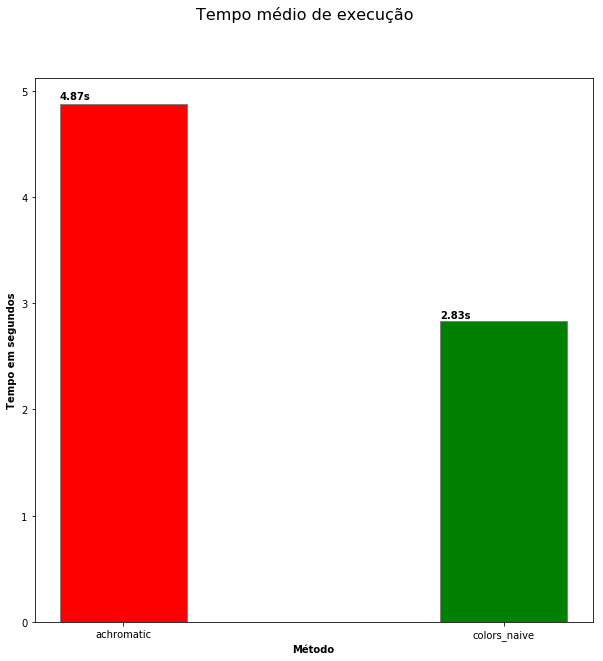

In [21]:
import matplotlib.pyplot as plt

# Tempo médio de execução
i=0
color = ['r', 'g', 'b', 'y', 'purple']
plt.figure(figsize=(10,10))
#methods = [ 'shapes_one_color','shapes','shapes_colors', 'colors_naive', 'colors']
#methods = ['colors_naive', 'hough_colors', 'achromatic']

for m in methods:
    ax = plt.bar(3*i,np.array(timeOfTrack[m]).mean(), color =color[i], width =1, edgecolor ='grey', label =m)
    for cont in ax.patches: 
        plt.text(cont.xy[0], cont.get_height()*1.01,  
                 str(format(cont.get_height(), '.2f'))+'s', 
                 fontsize = 10, fontweight ='bold', 
                 color ='black') 
    i+=1

# Adding Xticks  
plt.xlabel('Método', fontweight ='bold') 
plt.ylabel('Tempo em segundos', fontweight ='bold') 
plt.xticks(range(0,len(methods)*3, 3), 
           methods) 
plt.suptitle('Tempo médio de execução', fontsize=16)   
plt.savefig('../algorithm_performance_data/graphs/pynq/time_erosion.png')
plt.show()

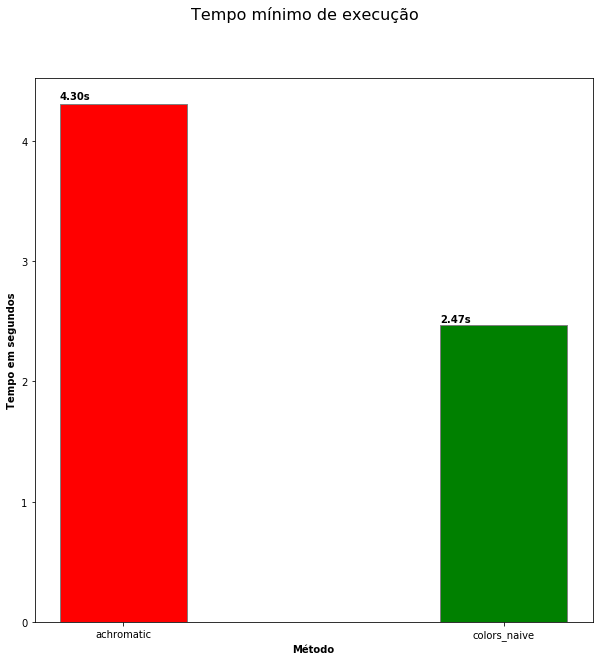

In [22]:
import matplotlib.pyplot as plt

# Tempo médio de execução
i=0
color = ['r', 'g', 'b', 'y', 'purple']
plt.figure(figsize=(10,10))
#methods = [ 'shapes_one_color','shapes','shapes_colors', 'colors_naive', 'colors']
#methods = ['colors_naive', 'hough_colors', 'achromatic']
for m in methods:
    ax = plt.bar(3*i,np.array(timeOfTrack[m]).min(), color =color[i], width =1, edgecolor ='grey', label =m)
    i+=1
    for cont in ax.patches: 
        plt.text(cont.xy[0], cont.get_height()*1.01,  
                 str(format(cont.get_height(), '.2f'))+'s', 
                 fontsize = 10, fontweight ='bold', 
                 color ='black') 

# Adding Xticks  
plt.xlabel('Método', fontweight ='bold') 
plt.ylabel('Tempo em segundos', fontweight ='bold') 
plt.xticks(range(0,len(methods)*3, 3), 
           methods) 
plt.suptitle('Tempo mínimo de execução', fontsize=16)   
plt.savefig('../algorithm_performance_data/graphs/pynq/time_min_erosion.png')
plt.show()

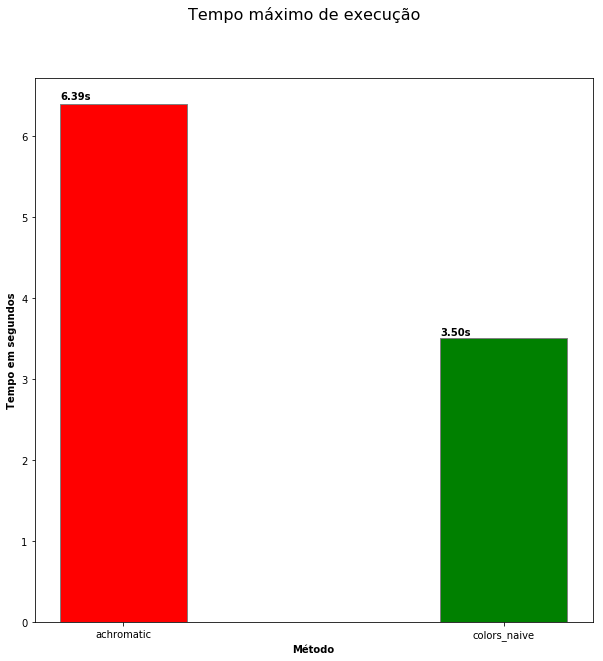

In [23]:
import matplotlib.pyplot as plt

# Tempo médio de execução
i=0
color = ['r', 'g', 'b', 'y', 'purple']
plt.figure(figsize=(10,10))
#methods = [ 'shapes_one_color','shapes','shapes_colors', 'colors_naive', 'colors']
#methods = ['colors_naive', 'hough_colors', 'achromatic']
for m in methods:
    ax = plt.bar(3*i,np.array(timeOfTrack[m]).max(), color =color[i], width =1, edgecolor ='grey', label =m)
    for cont in ax.patches: 
        plt.text(cont.xy[0], cont.get_height()+0.01*cont.get_height(),  
                 str(format(cont.get_height(), '.2f'))+'s', 
                 fontsize = 10, fontweight ='bold', 
                 color ='black') 
    i+=1

# Adding Xticks  
plt.xlabel('Método', fontweight ='bold') 
plt.ylabel('Tempo em segundos', fontweight ='bold') 
plt.xticks(range(0,len(methods)*3, 3), 
           methods) 
plt.suptitle('Tempo máximo de execução', fontsize=16)   
plt.savefig('../algorithm_performance_data/graphs/pynq/time_max_erosion.png')
plt.show()

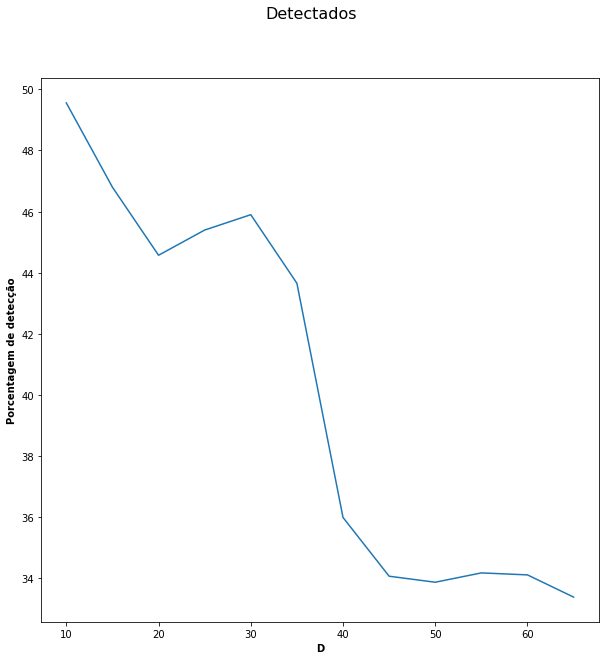

In [10]:
import matplotlib.pyplot as plt

# Tempo médio de execução
plt.figure(figsize=(10,10))

plt.plot(d_parameter, detected)

plt.xlabel('D', fontweight ='bold') 
plt.ylabel('Porcentagem de detecção', fontweight ='bold') 
plt.suptitle('Detectados', fontsize=16)   
plt.savefig('../algorithm_performance_data/graphs/28-3-2021/d_paramater_detected_conv_circ_5x5.png')
plt.show()

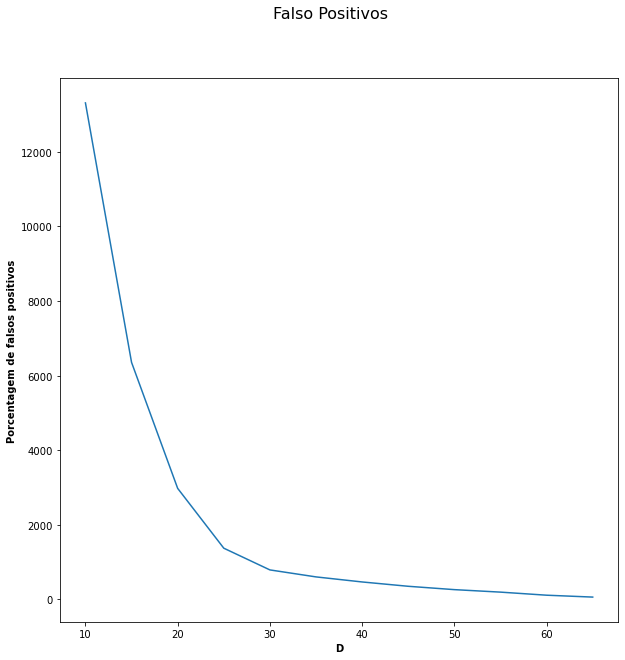

In [11]:
import matplotlib.pyplot as plt

# Tempo médio de execução
plt.figure(figsize=(10,10))

plt.plot(d_parameter, false_positive)

plt.xlabel('D', fontweight ='bold') 
plt.ylabel('Porcentagem de falsos positivos', fontweight ='bold') 
plt.suptitle('Falso Positivos', fontsize=16)   
plt.savefig('../algorithm_performance_data/graphs/28-3-2021/d_paramater_false_positive_conv_circ_5x5.png')
plt.show()

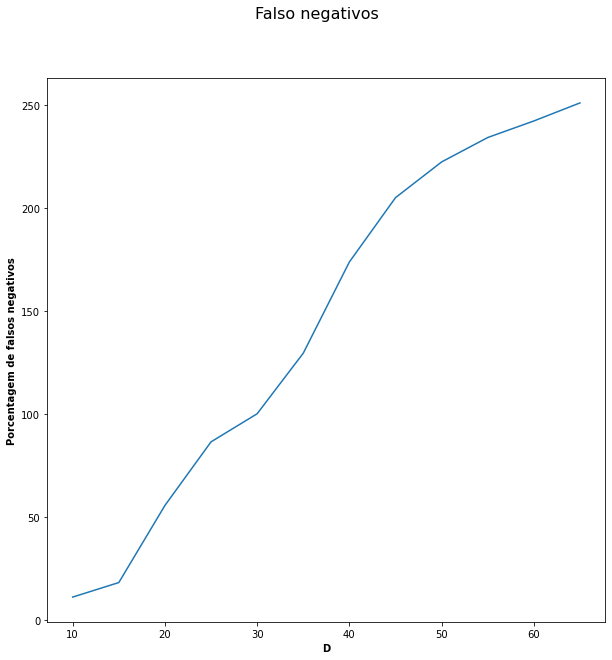

In [12]:
import matplotlib.pyplot as plt

# Tempo médio de execução
plt.figure(figsize=(10,10))

plt.plot(d_parameter, false_negative)

plt.xlabel('D', fontweight ='bold') 
plt.ylabel('Porcentagem de falsos negativos', fontweight ='bold') 
plt.suptitle('Falso negativos', fontsize=16)   
plt.savefig('../algorithm_performance_data/graphs/28-3-2021/d_paramater_false_negative_conv_circ_5x5.png')
plt.show()

In [2]:
import robot_color_tracking as track
import numpy as np

def calc_dist_error(calculated_positions, actual_positions):
    actual = np.array(actual_positions)
    calculated = np.array(calculated_positions)
    result = []
    false_negatives = 0

    for i in range(actual.size):
        if actual.size > 0 and calculated.size > 0:
            dist = calculated-actual[0]
            dist = np.sqrt(dist[:,0]**2+dist[:,1]**2)
            if(dist.min()<100):
                result.append(dist.min())
                calculated = np.delete(calculated, dist.argmin(), 0)
            else:
                false_negatives+=1
            actual = np.delete(actual, 0, 0)
        else:
            break

    false_positives = calculated.shape[0]
    false_negatives += actual.shape[0]

    return result, false_positives, false_negatives

trackers = {
    'achromatic': track.AchromaticTrack(d=30,img_width=500, binaryThreshold= 40,hueTolerance=15,
                                        satTolerance=0, kernel = np.ones((3,3)), convolution=True,
                                        colors=['blue','cyan', 'red', 'yellow'])
}

positions_data = tester.positions_data

data = positions_data['achromatic']

path = '../img/achromatic/'
counterProgress = 0
error={}
error['achromatic'] = {}
confusion_matrix = {'green': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 0, 'false': 0},
                    'red' :  {'green': 0, 'blue': 0, 'red': 0, 'yellow': 0, 'false': 0},
                    'blue':  {'green': 0, 'blue': 0, 'red': 0, 'yellow': 0, 'false': 0},
                    'yellow':{'green': 0, 'blue': 0, 'red': 0, 'yellow': 0, 'false': 0},
                    'false': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 0, 'false': 0},}
matrix_labels = ['green', 'blue', 'red', 'yellow']

# green_labeled_blue = 0
# blue_labeled_green = 0
# total = 0
m='acromatic'
for image in data:
    if(data[image]['place'] == 'daylight'):
    #     image ='IMG_20210108_134507.jpg'#'IMG_20210107_221450.jpg'
        print('\r'+'achromatic'+': '+str(format(100*counterProgress/len(data),'.2f'))+'%', end='')
        print('##################'+image+'##################')
        gb_false_n = 0
        bg_false_n = 0
        # Track and store actual and calculated poses
        trackers['achromatic'].track(path+image)
        calc_poses = trackers['achromatic'].getPoses()
        actual_poses = data[image]["position"]
        if m == 'achromatic' or 'colors_naive' or 'hough_colors':
            calc_poses['green'] = calc_poses['cyan']
            del(calc_poses['cyan'])
        print('')
        print(calc_poses)
        print('')
        print(actual_poses)
        print('')
        for calculated in matrix_labels:
            for actual in matrix_labels:
                if(actual in actual_poses):
                    green_labeled_red_list, fp, fn=calc_dist_error(calc_poses[calculated], actual_poses[actual])

                    confusion_matrix[calculated][actual] += len(green_labeled_red_list)

                    if(calculated == actual):
                        confusion_matrix['false'][actual] += fn
                        confusion_matrix[calculated]['false'] += fp
                    else:
                        confusion_matrix[calculated]['false'] -= len(green_labeled_red_list)

                elif(actual == calculated):
    #                 print(actual+' : '+str(len(calc_poses[actual])))
                    confusion_matrix[actual]['false'] += len(calc_poses[actual])
        
        print(confusion_matrix)

        counterProgress+=1
        
print('\r'+'achromatic:'+format(100*counterProgress/len(data),'.2f')+'%')
# print('\n'+str(confusion_matrix))

achromatic: 0.00%##################IMG_20210108_125325.jpg##################

{'blue': [], 'red': array([[3265.03272727,  561.31636364],
       [3144.96      ,  565.76      ],
       [3104.14      ,  633.62      ],
       [ 264.73234899, 3066.05959732]]), 'yellow': array([[2069.99581761, 1557.91307246]]), 'green': array([[3243.64444444,  677.15555556]])}

{'green': [[3264, 693]]}

{'green': {'green': 1, 'blue': 0, 'red': 0, 'yellow': 0, 'false': 0}, 'red': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 0, 'false': 4}, 'blue': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 0, 'false': 0}, 'yellow': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 0, 'false': 1}, 'false': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 0, 'false': 0}}
achromatic: 0.26%##################IMG_20210108_125336.jpg##################

{'blue': [], 'red': array([[3257.28      ,  561.98697674],
       [3124.16      ,  603.2       ]]), 'yellow': array([[2069.47304001, 1560.53805993]]), 'green': array([[3245.77882353,  679.058823


{'blue': [], 'red': [], 'yellow': array([[3714.88,  282.88]]), 'green': []}

{'yellow': [[3731, 315]]}

{'green': {'green': 12, 'blue': 0, 'red': 0, 'yellow': 0, 'false': 0}, 'red': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 0, 'false': 6}, 'blue': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 0, 'false': 0}, 'yellow': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 2, 'false': 2}, 'false': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 2, 'false': 0}}
achromatic: 4.11%##################IMG_20210108_132257.jpg##################

{'blue': [], 'red': [], 'yellow': [], 'green': []}

{'yellow': [[3313, 1742]]}

{'green': {'green': 12, 'blue': 0, 'red': 0, 'yellow': 0, 'false': 0}, 'red': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 0, 'false': 6}, 'blue': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 0, 'false': 0}, 'yellow': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 2, 'false': 2}, 'false': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 3, 'false': 0}}
achromatic: 4.37%##################IMG_20210108


{'blue': array([[3277.35652174, 1376.23652174]]), 'red': [], 'yellow': [], 'green': []}

{'blue': [[3290, 1403]]}

{'green': {'green': 12, 'blue': 5, 'red': 0, 'yellow': 0, 'false': 0}, 'red': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 0, 'false': 6}, 'blue': {'green': 0, 'blue': 10, 'red': 0, 'yellow': 0, 'false': 0}, 'yellow': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 2, 'false': 2}, 'false': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 8, 'false': 0}}
achromatic: 8.23%##################IMG_20210108_132552.jpg##################

{'blue': [], 'red': [], 'yellow': [], 'green': []}

{'red': [[2352, 1603]]}

{'green': {'green': 12, 'blue': 5, 'red': 0, 'yellow': 0, 'false': 0}, 'red': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 0, 'false': 6}, 'blue': {'green': 0, 'blue': 10, 'red': 0, 'yellow': 0, 'false': 0}, 'yellow': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 2, 'false': 2}, 'false': {'green': 0, 'blue': 0, 'red': 1, 'yellow': 8, 'false': 0}}
achromatic: 8.48%##################IM


{'blue': [], 'red': array([[3806.4 ,  457.6 ],
       [3931.52,  472.96]]), 'yellow': [], 'green': []}

{'red': [[3880, 570], [3940, 478], [3831, 478]]}

{'green': {'green': 12, 'blue': 5, 'red': 0, 'yellow': 0, 'false': 0}, 'red': {'green': 0, 'blue': 0, 'red': 11, 'yellow': 0, 'false': 7}, 'blue': {'green': 0, 'blue': 10, 'red': 0, 'yellow': 0, 'false': 0}, 'yellow': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 2, 'false': 2}, 'false': {'green': 0, 'blue': 0, 'red': 17, 'yellow': 8, 'false': 0}}
achromatic: 12.34%##################IMG_20210108_133321.jpg##################

{'blue': [], 'red': array([[3274.752, 1785.472]]), 'yellow': [], 'green': []}

{'red': [[3148, 1812], [3180, 1712], [3275, 1785]]}

{'green': {'green': 12, 'blue': 5, 'red': 0, 'yellow': 0, 'false': 0}, 'red': {'green': 0, 'blue': 0, 'red': 12, 'yellow': 0, 'false': 7}, 'blue': {'green': 0, 'blue': 10, 'red': 0, 'yellow': 0, 'false': 0}, 'yellow': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 2, 'false': 2}, 'false':


{'blue': [], 'red': [], 'yellow': [], 'green': array([[2040.20266667, 1244.94933333],
       [1981.66032787, 1342.65704918],
       [2097.16825397, 1350.21714286]])}

{'green': [[1998, 1356], [2062, 1273], [2139, 1379]]}

{'green': {'green': 40, 'blue': 5, 'red': 0, 'yellow': 0, 'false': 0}, 'red': {'green': 0, 'blue': 0, 'red': 15, 'yellow': 0, 'false': 7}, 'blue': {'green': 0, 'blue': 10, 'red': 0, 'yellow': 0, 'false': 0}, 'yellow': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 2, 'false': 2}, 'false': {'green': 2, 'blue': 0, 'red': 25, 'yellow': 8, 'false': 0}}
achromatic: 15.94%##################IMG_20210108_133553.jpg##################

{'blue': array([[1941.19804878, 1441.99804878],
       [1865.24      , 1533.13333333],
       [1976.        , 1565.03578947]]), 'red': [], 'yellow': [], 'green': array([[1872.  , 1564.16],
       [1988.48, 1597.44]])}

{'blue': [[2004, 1592], [1969, 1467], [1880, 1566]]}

{'green': {'green': 40, 'blue': 7, 'red': 0, 'yellow': 0, 'false': 0}, 'red':


{'blue': [], 'red': [], 'yellow': array([[3701.49565217,  512.76521739],
       [3640.77037037,  615.0637037 ],
       [3762.96186047,  619.54976744]]), 'green': []}

{'yellow': [[3659, 638], [3720, 538], [3776, 656]]}

{'green': {'green': 40, 'blue': 9, 'red': 0, 'yellow': 0, 'false': 0}, 'red': {'green': 0, 'blue': 0, 'red': 15, 'yellow': 0, 'false': 8}, 'blue': {'green': 0, 'blue': 36, 'red': 0, 'yellow': 0, 'false': 0}, 'yellow': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 14, 'false': 2}, 'false': {'green': 2, 'blue': 1, 'red': 25, 'yellow': 8, 'false': 0}}
achromatic: 19.28%##################IMG_20210108_133814.jpg##################

{'blue': [], 'red': [], 'yellow': array([[3116.51096774, 1602.00258065],
       [2996.06068966, 1628.71172414],
       [3077.64363636, 1722.99636364]]), 'green': []}

{'yellow': [[3071, 1733], [3138, 1617], [3029, 1647]]}

{'green': {'green': 40, 'blue': 9, 'red': 0, 'yellow': 0, 'false': 0}, 'red': {'green': 0, 'blue': 0, 'red': 15, 'yellow': 0, 'f


{'blue': array([[2547.71891892,  602.63783784],
       [2660.53894737,  600.46315789],
       [2607.29962264,  697.46716981]]), 'red': array([[1435.2   , 1971.84  ],
       [1118.5408, 2636.7744],
       [1223.04  , 2728.96  ]]), 'yellow': array([[1483.33714286, 2080.71314286],
       [1371.41333333, 2137.84380952],
       [1476.8       , 2204.8       ]]), 'green': array([[2254.1559322 , 1077.65152542],
       [2154.63529412, 1124.30117647],
       [2238.45818182, 1196.0630303 ]])}

{'blue': [[2641, 734], [2692, 614], [2559, 609]], 'green': [[2256, 1231], [2265, 1082], [2175, 1152]], 'yellow': [[1519, 2240], [1507, 2086], [1376, 2168]], 'red': [[1243, 2739], [1279, 2647], [1127, 2664]]}

{'green': {'green': 55, 'blue': 9, 'red': 0, 'yellow': 0, 'false': 0}, 'red': {'green': 0, 'blue': 0, 'red': 24, 'yellow': 0, 'false': 9}, 'blue': {'green': 0, 'blue': 50, 'red': 0, 'yellow': 0, 'false': 0}, 'yellow': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 43, 'false': 2}, 'false': {'green': 2, '


{'blue': array([[3477.50787879, 1112.35878788]]), 'red': [], 'yellow': array([[3157.44, 2329.6 ]]), 'green': array([[3467.71862069, 1071.27172414],
       [2122.88761905, 1215.51238095]])}

{'green': [[2133, 1216]], 'blue': [[3486, 1128]], 'yellow': [[3178, 2362]], 'red': [[928, 1779]]}

{'green': {'green': 70, 'blue': 17, 'red': 3, 'yellow': 3, 'false': 4}, 'red': {'green': 0, 'blue': 0, 'red': 30, 'yellow': 0, 'false': 9}, 'blue': {'green': 0, 'blue': 63, 'red': 2, 'yellow': 2, 'false': 0}, 'yellow': {'green': 0, 'blue': 0, 'red': 0, 'yellow': 55, 'false': 2}, 'false': {'green': 2, 'blue': 4, 'red': 40, 'yellow': 15, 'false': 0}}
achromatic: 24.42%##################IMG_20210108_161725.jpg##################

{'blue': [], 'red': [], 'yellow': array([[3064.88, 2693.86]]), 'green': array([[ 170.56      ,  307.84      ],
       [3467.54909091, 1076.68363636],
       [3502.72      , 1148.16      ],
       [1850.16      , 2666.88842105],
       [3126.76      , 2747.16      ]])}

{'red': [[

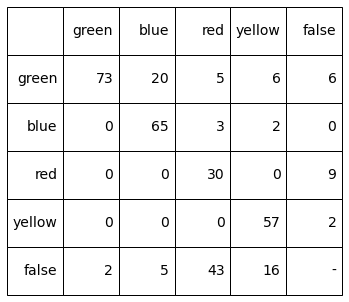

In [3]:
import numpy as np
import matplotlib.pyplot as plt 

#define figure and axes
fig, ax = plt.subplots()

#create values for table
table_data=[['','green', 'blue', 'red', 'yellow','false'],
            ['green',confusion_matrix['green']['green'], confusion_matrix['green']['blue'], confusion_matrix['green']['red'], confusion_matrix['green']['yellow'],confusion_matrix['green']['false']],
            ['blue',confusion_matrix['blue']['green'], confusion_matrix['blue']['blue'], confusion_matrix['blue']['red'], confusion_matrix['blue']['yellow'],confusion_matrix['blue']['false']],
            ['red',confusion_matrix['red']['green'], confusion_matrix['red']['blue'], confusion_matrix['red']['red'], confusion_matrix['red']['yellow'],confusion_matrix['red']['false']],
            ['yellow',confusion_matrix['yellow']['green'], confusion_matrix['yellow']['blue'], confusion_matrix['yellow']['red'], confusion_matrix['yellow']['yellow'],confusion_matrix['yellow']['false']],
            ['false',confusion_matrix['false']['green'], confusion_matrix['false']['blue'], confusion_matrix['false']['red'], confusion_matrix['false']['yellow'],'-'],]

#create table
table = ax.table(cellText=table_data, loc='center')

#modify table
table.set_fontsize(14)
table.scale(1,4)
ax.axis('off')

#display table
plt.savefig('../algorithm_performance_data/graphs/daylight_confusion_matrix.png')
plt.show()

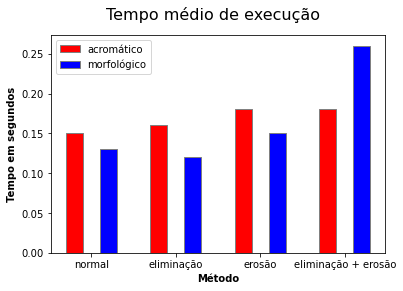

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Tempo médio de execução
# i=0
# color = ['r', 'g', 'b', 'y', 'purple']
# plt.figure(figsize=(10,10))
# #methods = [ 'shapes_one_color','shapes','shapes_colors', 'colors_naive', 'colors']
# #methods = ['colors_naive', 'hough_colors', 'achromatic']
# for m in methods:
#     ax = plt.bar(3*i,np.array(timeOfTrack[m]).max(), color =color[i], width =1, edgecolor ='grey', label =m)
#     for cont in ax.patches: 
#         plt.text(cont.xy[0], cont.get_height()+0.01*cont.get_height(),  
#                  str(format(cont.get_height(), '.2f'))+'s', 
#                  fontsize = 10, fontweight ='bold', 
#                  color ='black') 
#     i+=1

# # Adding Xticks  
# plt.xlabel('Método', fontweight ='bold') 
# plt.ylabel('Tempo em segundos', fontweight ='bold') 
# plt.xticks(range(0,len(methods)*3, 3), 
#            methods) 
# plt.suptitle('Tempo máximo de execução', fontsize=16)   
# plt.savefig('../algorithm_performance_data/graphs/12-4-2021-meeting/time_max_elimination_center.png')
# plt.show()

ax = plt.bar(0, 0.15, color ='red', width =1, edgecolor ='grey', label = 'acromático')
ax = plt.bar(2, 0.13, color ='blue', width =1, edgecolor ='grey', label='morfológico')
ax = plt.bar(5, 0.16, color ='red', width =1, edgecolor ='grey')
ax = plt.bar(7, 0.12, color ='blue', width =1, edgecolor ='grey')

ax = plt.bar(10, 0.18, color ='red', width =1, edgecolor ='grey')
ax = plt.bar(12, 0.15, color ='blue', width =1, edgecolor ='grey')
ax = plt.bar(15, 0.18, color ='red', width =1, edgecolor ='grey')
ax = plt.bar(17, 0.26, color ='blue', width =1, edgecolor ='grey')

plt.xlabel('Método', fontweight ='bold') 
plt.ylabel('Tempo em segundos', fontweight ='bold') 
plt.xticks([1,6,11, 16], ['normal', 'eliminação', 'erosão', 'eliminação + erosão']) 
plt.legend()
plt.suptitle('Tempo médio de execução', fontsize=16)   
plt.savefig('../algorithm_performance_data/graphs/12-4-2021-meeting/tempo_medio_todos.png')
plt.show()